In [1]:
from torchvision import datasets
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_folder = '~/data/FMNIST'

fmnist = datasets.FashionMNIST(data_folder, 
                               download=True,
                               train=True)


#dividindo entre treino e validação

tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist = datasets.FashionMNIST(data_folder, 
                                   download=True,
                                   train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [3]:
#configurando as transformações a serem realizadas nas imagens

from imgaug import augmenters as iaa
aug = iaa.Sequential([
    iaa.Affine(translate_px={'x':(-10,10)},
        mode='constant'),
])

In [4]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y, aug=None):
        self.x, self.y = x, y
        self.aug = aug
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x, y
    def __len__(self): return len(self.x)

    def collate_fn(self, batch):
        'logic to modify a batch of images'
        ims, classes = list(zip(*batch))
        if self.aug: 
          ims_np = np.array([tensor.numpy() for tensor in ims])
          ims=self.aug.augment_images(images=ims_np)
          

        ims = torch.tensor(ims)[:,None,:,:].to(device)/255.
        classes = torch.tensor(classes).to(device)
        return ims, classes

In [5]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [6]:
#função para treinar um único batch

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [7]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets, aug=aug)
    trn_dl = DataLoader(train, batch_size=64,
                collate_fn=train.collate_fn, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images),
                collate_fn=val.collate_fn, shuffle=True)
    return trn_dl, val_dl

In [8]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
for epoch in range(5):
    print(epoch)
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

0
1
2
3
4


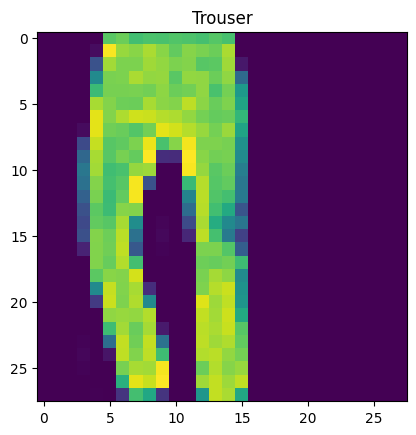

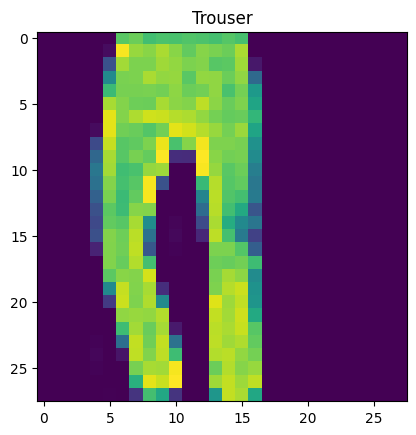

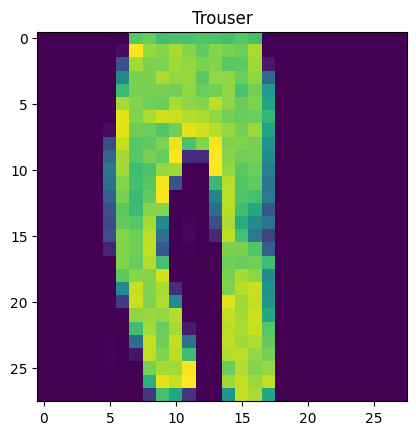

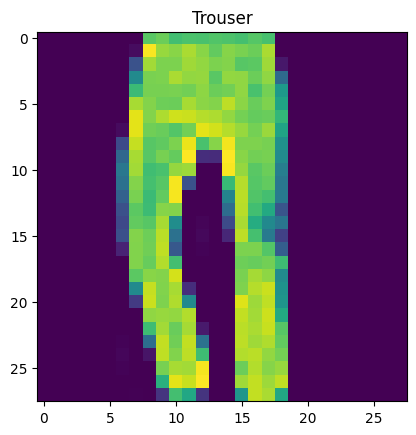

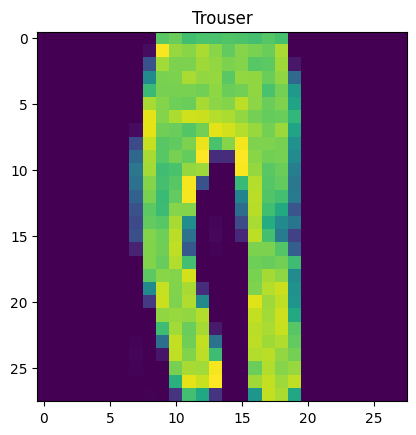

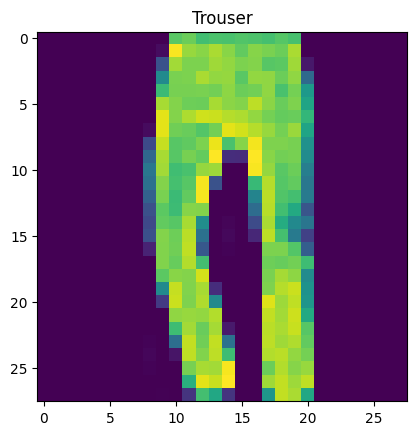

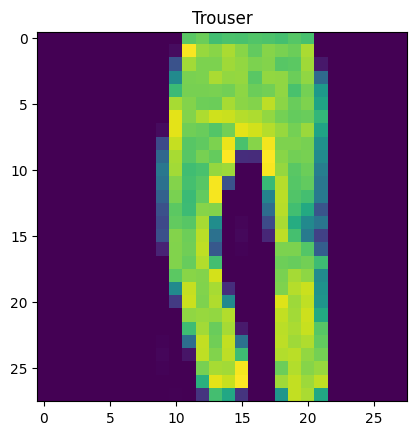

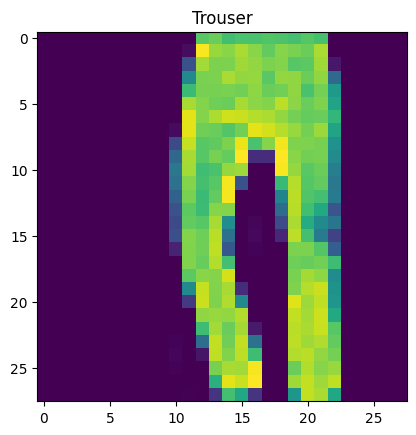

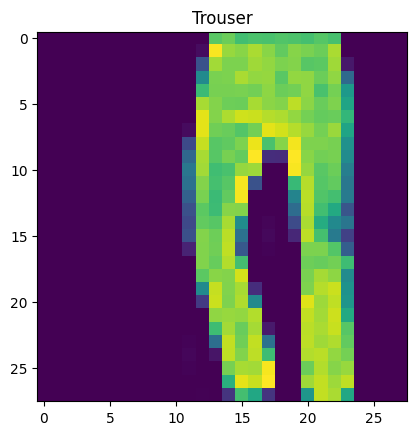

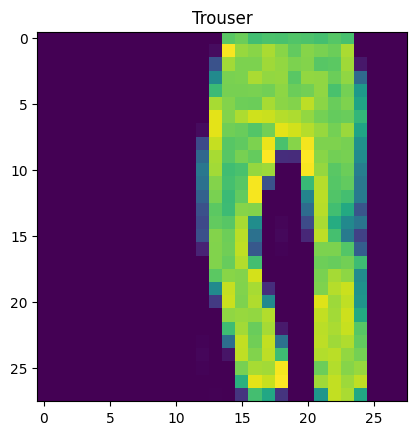

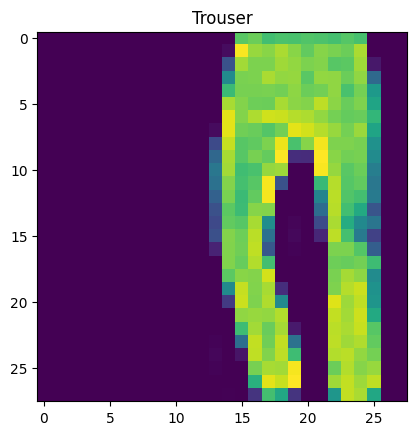

In [9]:
preds = []
ix = 24300
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output)/np.sum(np.exp(np_output))
    preds.append(pred)
    plt.imshow(img2)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()